In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_table('SMSSpamCollection', header=None, quoting=3, names=['class', 'message'])

In [2]:
print len(df)
print df.shape
print df.head()

5574
(5574, 2)
  class                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [3]:
df_train, df_test, y_train, y_test = train_test_split(df['message'], df['class'], test_size=0.33, random_state=42)

In [4]:
# We will use pre-trained vectors from Glove project for vectorizing messages. That's how we will be able to classify effectively even messages with words that were not in the training set. Glove will provide the semantic connotations between the words in our traing set and words from future data.

# Glove pre-trained vectors needed. Download from https://nlp.stanford.edu/projects/glove/

# Constructing word to vector dictionary
with open("glove.840B.300d.txt", "rb") as lines:
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:])) for line in lines}

# We need to create our own implementation of TF-IDF Vectorizer using Glove w2v    
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.itervalues().next())

    def fit(self, X):
        tfidf = TfidfVectorizer()
        tfidf.fit(X)

        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w] for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X])

# vectorizing the data    
vectorizer = TfidfEmbeddingVectorizer(w2v)

vectorizer.fit(df_train)
X_train = vectorizer.transform(df_train)
X_test = vectorizer.transform(df_test)

In [7]:
# We will use Gradient Boosting Classifier which yielded the best results in previous iteration

clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.02, max_depth=8, random_state=0, min_samples_leaf=0.001)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      1585
       spam       0.98      0.87      0.92       255

avg / total       0.98      0.98      0.98      1840

[[1580    5]
 [  33  222]]


In [8]:
# The model is a little bit worse than the best one that we aquired. However, it is still very solid model - comparable with customized Logistic Regression model from 00 iteration.

# The big advantage of this model is though, that it can classify messages even with words that were not present in the training set (because it uses pre-trained word vectors). Considering the fact that the training set was rather small, this is a very useful finding.

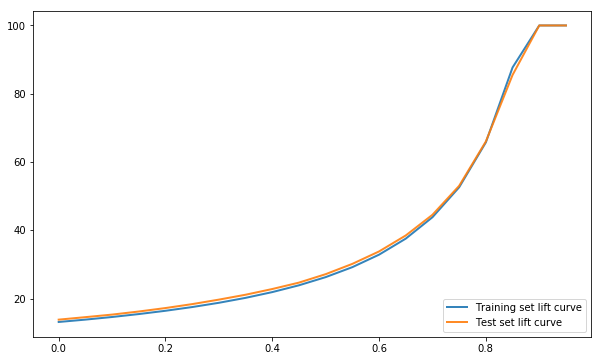

In [10]:
# Cumultative Lift Charts

# scoring training and test sets
y_tr_pred = clf.predict_proba(X_train)[:,1]
y_ts_pred = clf.predict_proba(X_test)[:,1]

# sorting them
tr = sorted(zip(y_tr_pred, y_train == 'spam'), key=lambda x: x[0], reverse=True)
ts = sorted(zip(y_ts_pred, y_test == 'spam'), key=lambda x: x[0], reverse=True)

# average score in each bin
cumulated = {0: [], 1: []}
for i, s in enumerate([tr, ts]):
    scores = []
    for group in np.array_split(s, 20):
        scores += [x[1] for x in group]
        cumulated[i].append(np.mean(scores) * 100)

# plotting
bins = [x / 100. for x in reversed(range(0 , 100, 5))]

plt.rcParams["figure.figsize"] = [10,6]

plt.plot(bins, cumulated[0], lw=2, alpha=0.9, label="Training set lift curve")
plt.plot(bins, cumulated[1], lw=2, alpha=0.9, label="Test set lift curve")

plt.legend(loc='lower right')

# Cumultative Lift Charts for training and test sets are smooth and close to each other. Thus, the model is less likely to be overtrained or overfitted.